# Задание выполнил студент Иванов Тимофей из группы ПИЭ-13МО

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Номер 1) Анализ полиномиальных данных

In [58]:
poly_data = pd.read_csv('hw2_polynomial_data.csv')
X_poly = poly_data[['x0', 'x1', 'x2']]
y_poly = poly_data['y']

print(f'Размерность данных: {X_poly.shape}')

# Создание полиномиальных признаков со степенью 3
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_features = poly.fit_transform(X_poly)

feature_names = poly.get_feature_names_out(['x0', 'x1', 'x2'])
print(f'Количество полиномиальных признаков: {len(feature_names)}')

# Используем LassoCV для автоматического подбора коэффициента регуляризации
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_poly_features, y_poly)

print(f'Лучший alpha для Lasso: {lasso_cv.alpha_:.6f}')

# Получаем ненулевые коэффициенты
nonzero_coef = lasso_cv.coef_ != 0
selected_features = feature_names[nonzero_coef]
selected_coef = lasso_cv.coef_[nonzero_coef]

print("\nЗначимые полиномиальные члены:")
for feature, coef in zip(selected_features, selected_coef):
    print(f'{feature}:   {coef:+.3f}')

# Проверяем качество модели
y_pred = lasso_cv.predict(X_poly_features)
r2 = r2_score(y_poly, y_pred)
print(f'\nR^2 оценка на данных: {r2:.3f}')

Размерность данных: (500, 3)
Количество полиномиальных признаков: 19
Лучший alpha для Lasso: 0.646047

Значимые полиномиальные члены:
x1:   +0.550
x0 x1:   +1.607
x0 x2:   -0.472
x1 x2:   +1.769
x2^2:   -0.097
x0^3:   -0.015
x0 x1 x2:   -0.870
x0 x2^2:   +0.298
x1^2 x2:   +0.232
x1 x2^2:   -1.121
x2^3:   +0.265

R^2 оценка на данных: 0.695


## Номер 2) Несложная нелинейная зависимость

Лучший alpha для Ridge: 0.000001
Лучший alpha для Lasso: 0.000100
Linear: MSE = 0.025554
Ridge (alpha=0.000001): MSE = 0.025207
Lasso (alpha=0.000100): MSE = 0.091219


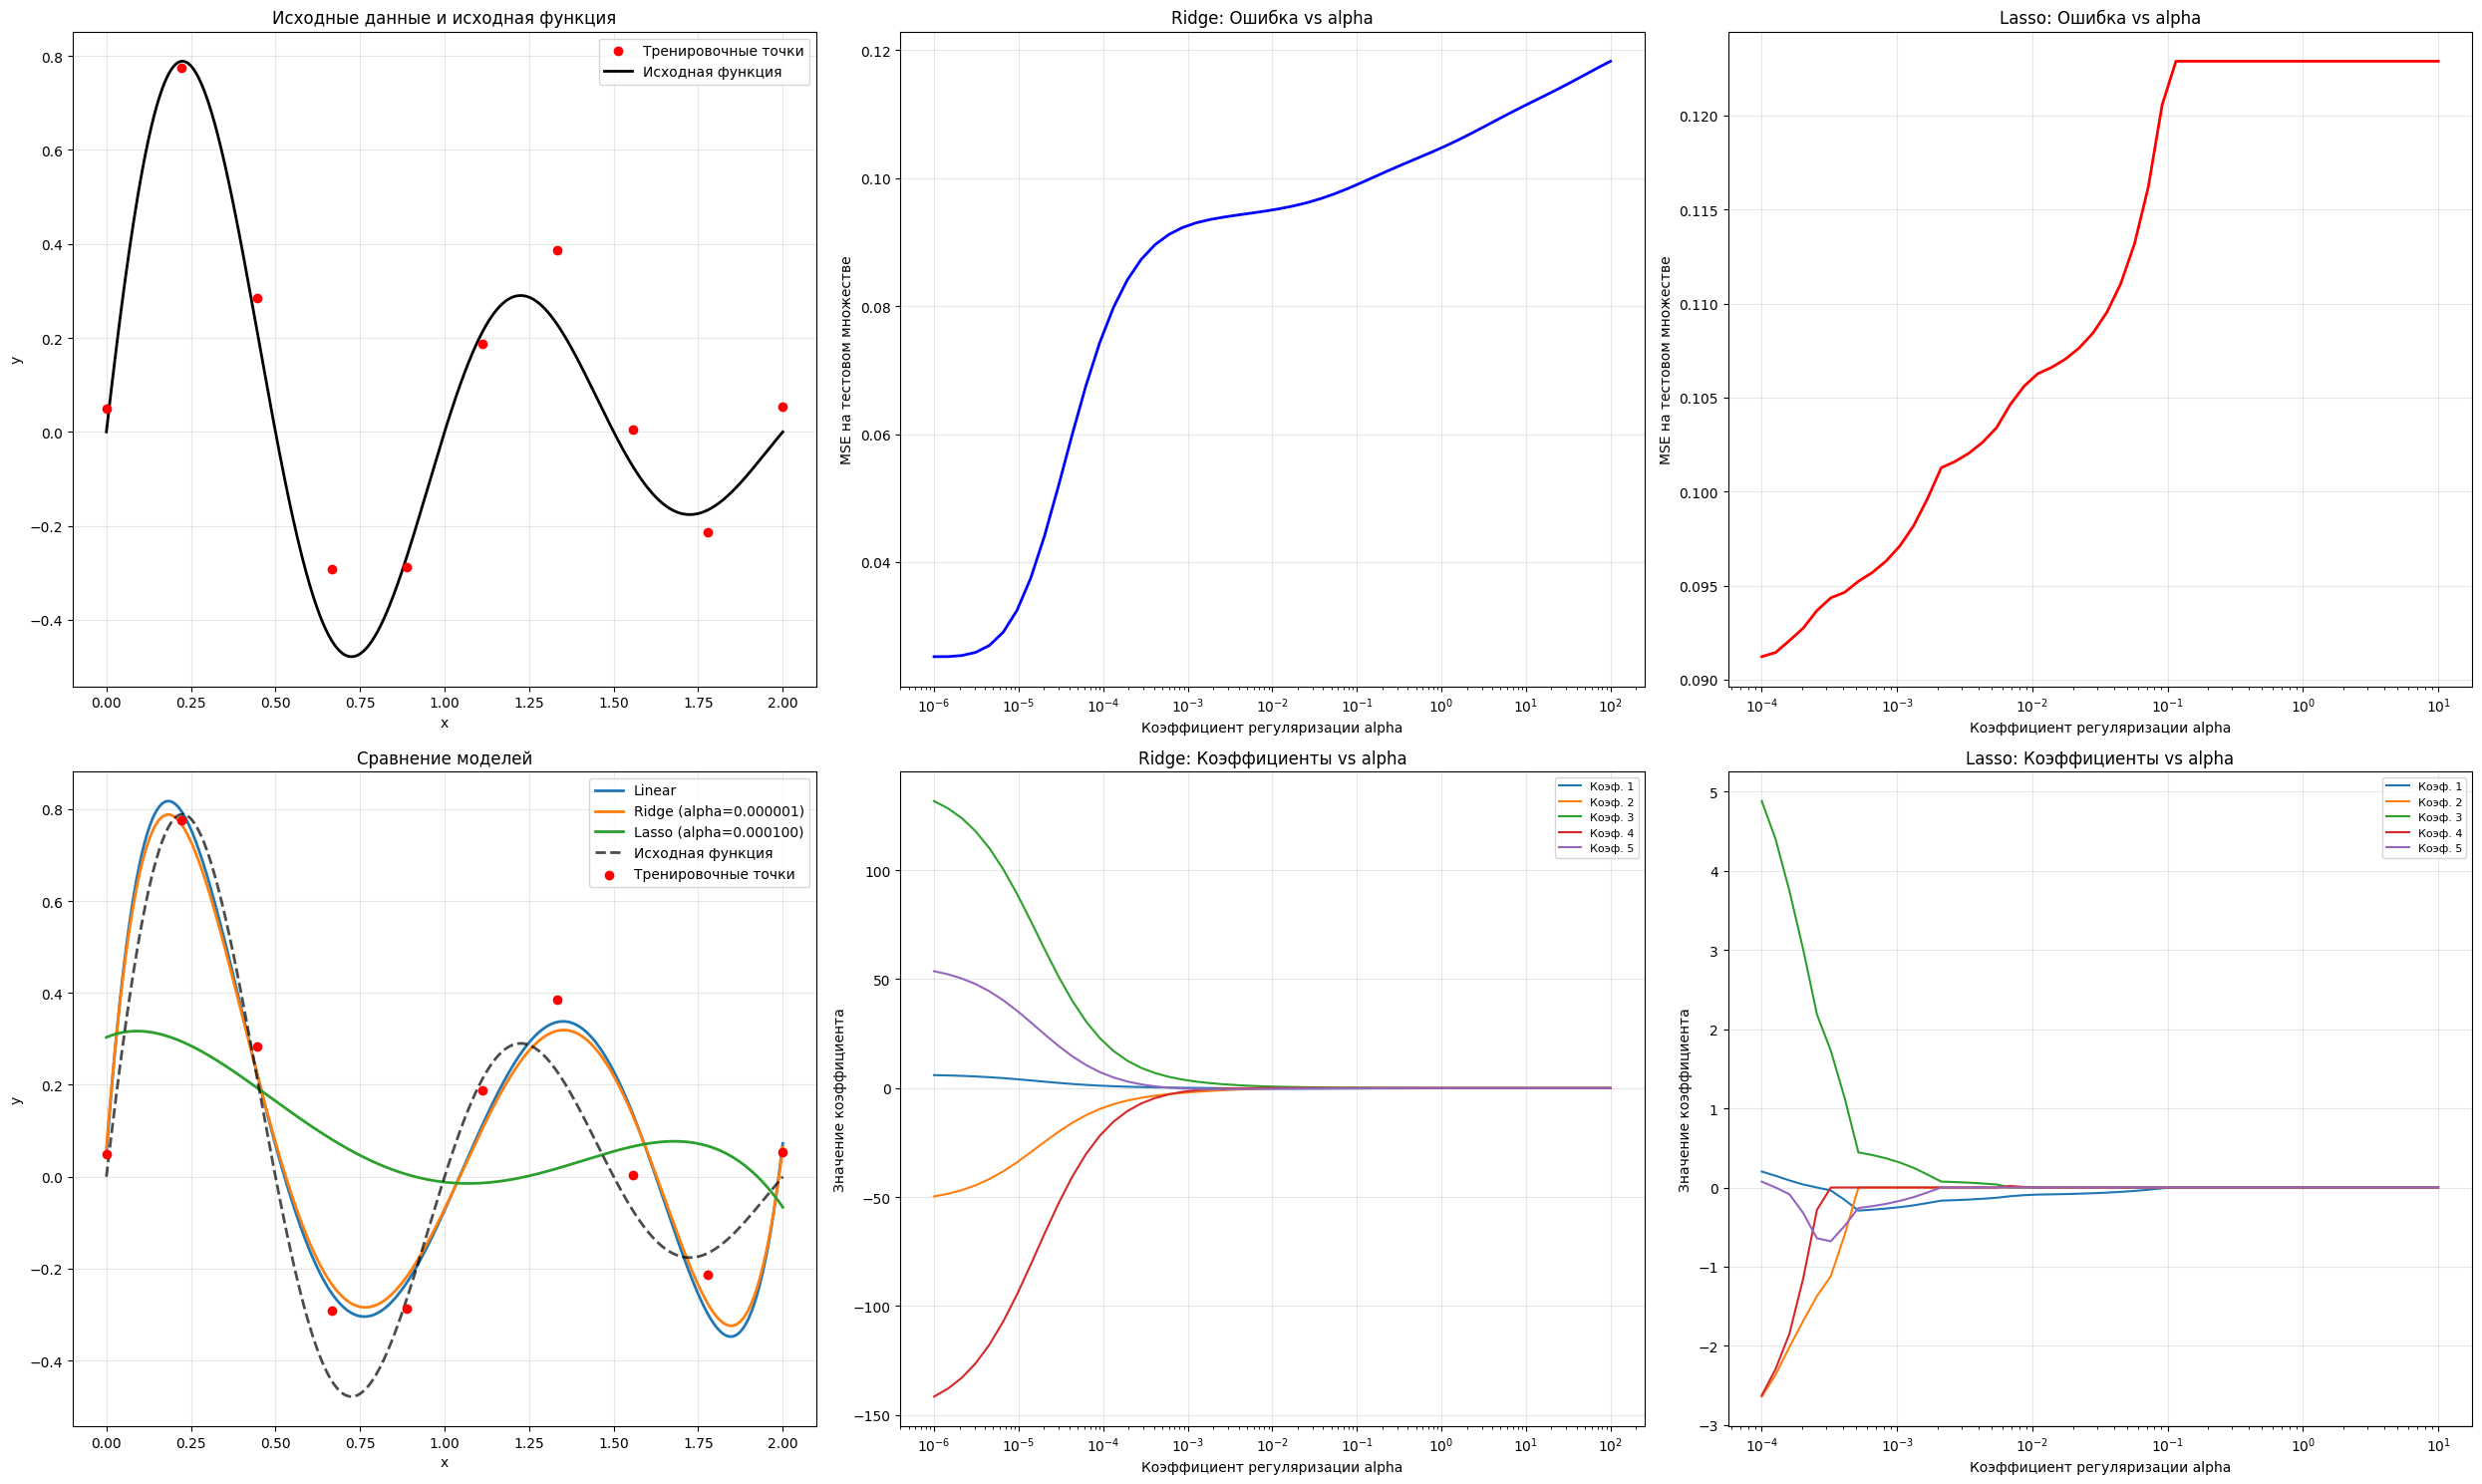

In [59]:
# Генерируем данные
np.random.seed(42)

def true_function(x):
    return np.exp(-x) * np.sin(2 * np.pi * x)

# Тренировочные данные
X_train_small = np.linspace(0, 2, 10).reshape(-1, 1)
y_train_small = true_function(X_train_small).ravel() + np.random.normal(0, 0.1, 10)

# Тестовые данные
X_test = np.linspace(0, 2, 500).reshape(-1, 1)
y_test = true_function(X_test).ravel() + np.random.normal(0, 0.1, 500)

# Создаём полиномиальные признаки со степенью 5
poly_transformer = PolynomialFeatures(degree=5, include_bias=False)

# Исследуем Ridge регрессию
alphas_ridge = np.logspace(-6, 2, 50)
ridge_errors = []
ridge_coefs = []

for alpha in alphas_ridge:
    model = Pipeline([
        ('poly', poly_transformer),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha))
    ])
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test)
    ridge_errors.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(model.named_steps['ridge'].coef_)

# Исследуем Lasso регресси.
alphas_lasso = np.logspace(-4, 1, 50)
lasso_errors = []
lasso_coefs = []

for alpha in alphas_lasso:
    model = Pipeline([
        ('poly', poly_transformer),
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=alpha, max_iter=10000))
    ])
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test)
    lasso_errors.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(model.named_steps['lasso'].coef_)

# Строим графики
fig, axes = plt.subplots(2, 3, figsize=(25, 15))

# График исходной функции
axes[0, 0].scatter(X_train_small, y_train_small, color='red', label='Тренировочные точки', zorder=5)
axes[0, 0].plot(X_test, true_function(X_test), 'k-', label='Исходная функция', linewidth=2)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].set_title('Исходные данные и исходная функция')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Ошибка vs alpha для Ridge
axes[0, 1].semilogx(alphas_ridge, ridge_errors, 'b-', linewidth=2)
axes[0, 1].set_xlabel('Коэффициент регуляризации alpha')
axes[0, 1].set_ylabel('MSE на тестовом множестве')
axes[0, 1].set_title('Ridge: Ошибка vs alpha')
axes[0, 1].grid(True, alpha=0.3)

# Ошибка vs alpha для Lasso
axes[0, 2].semilogx(alphas_lasso, lasso_errors, 'r-', linewidth=2)
axes[0, 2].set_xlabel('Коэффициент регуляризации alpha')
axes[0, 2].set_ylabel('MSE на тестовом множестве')
axes[0, 2].set_title('Lasso: Ошибка vs alpha')
axes[0, 2].grid(True, alpha=0.3)

# Коэффициенты vs alpha для Ridge
ridge_coefs = np.array(ridge_coefs)
for i in range(ridge_coefs.shape[1]):
    axes[1, 1].semilogx(alphas_ridge, ridge_coefs[:, i], label=f'Коэф. {i+1}')
axes[1, 1].set_xlabel('Коэффициент регуляризации alpha')
axes[1, 1].set_ylabel('Значение коэффициента')
axes[1, 1].set_title('Ridge: Коэффициенты vs alpha')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

# Коэффициенты vs alpha для Lasso
lasso_coefs = np.array(lasso_coefs)
for i in range(lasso_coefs.shape[1]):
    axes[1, 2].semilogx(alphas_lasso, lasso_coefs[:, i], label=f'Коэф. {i+1}')
axes[1, 2].set_xlabel('Коэффициент регуляризации alpha')
axes[1, 2].set_ylabel('Значение коэффициента')
axes[1, 2].set_title('Lasso: Коэффициенты vs alpha')
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

# Сравнение моделей с лучшими параметрами
best_ridge_alpha = alphas_ridge[np.argmin(ridge_errors)]
best_lasso_alpha = alphas_lasso[np.argmin(lasso_errors)]

print(f'Лучший alpha для Ridge: {best_ridge_alpha:.6f}')
print(f'Лучший alpha для Lasso: {best_lasso_alpha:.6f}')

# Модели с лучшими параметрами
models = {
    'Linear': Pipeline([
        ('poly', poly_transformer),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    f'Ridge (alpha={best_ridge_alpha:.6f})': Pipeline([
        ('poly', poly_transformer),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=best_ridge_alpha))
    ]),
    f'Lasso (alpha={best_lasso_alpha:.6f})': Pipeline([
        ('poly', poly_transformer),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=best_lasso_alpha, max_iter=10000))
    ])
}

# Обучение и прогнозирование
for name, model in models.items():
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: MSE = {mse:.6f}")

# Визуализация предсказаний
for name, model in models.items():
    y_pred = model.predict(X_test)
    axes[1, 0].plot(X_test, y_pred, label=name, linewidth=2)

axes[1, 0].plot(X_test, true_function(X_test), 'k--', label='Исходная функция', linewidth=2, alpha=0.7)
axes[1, 0].scatter(X_train_small, y_train_small, color='red', label='Тренировочные точки', zorder=5)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
axes[1, 0].set_title('Сравнение моделей')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Номер 3) Обучение линейной регрессии и анализ датасета

Размерность данных: (200, 1)
Линейная регрессия - R^2: 0.7870, MSE: 19.7948


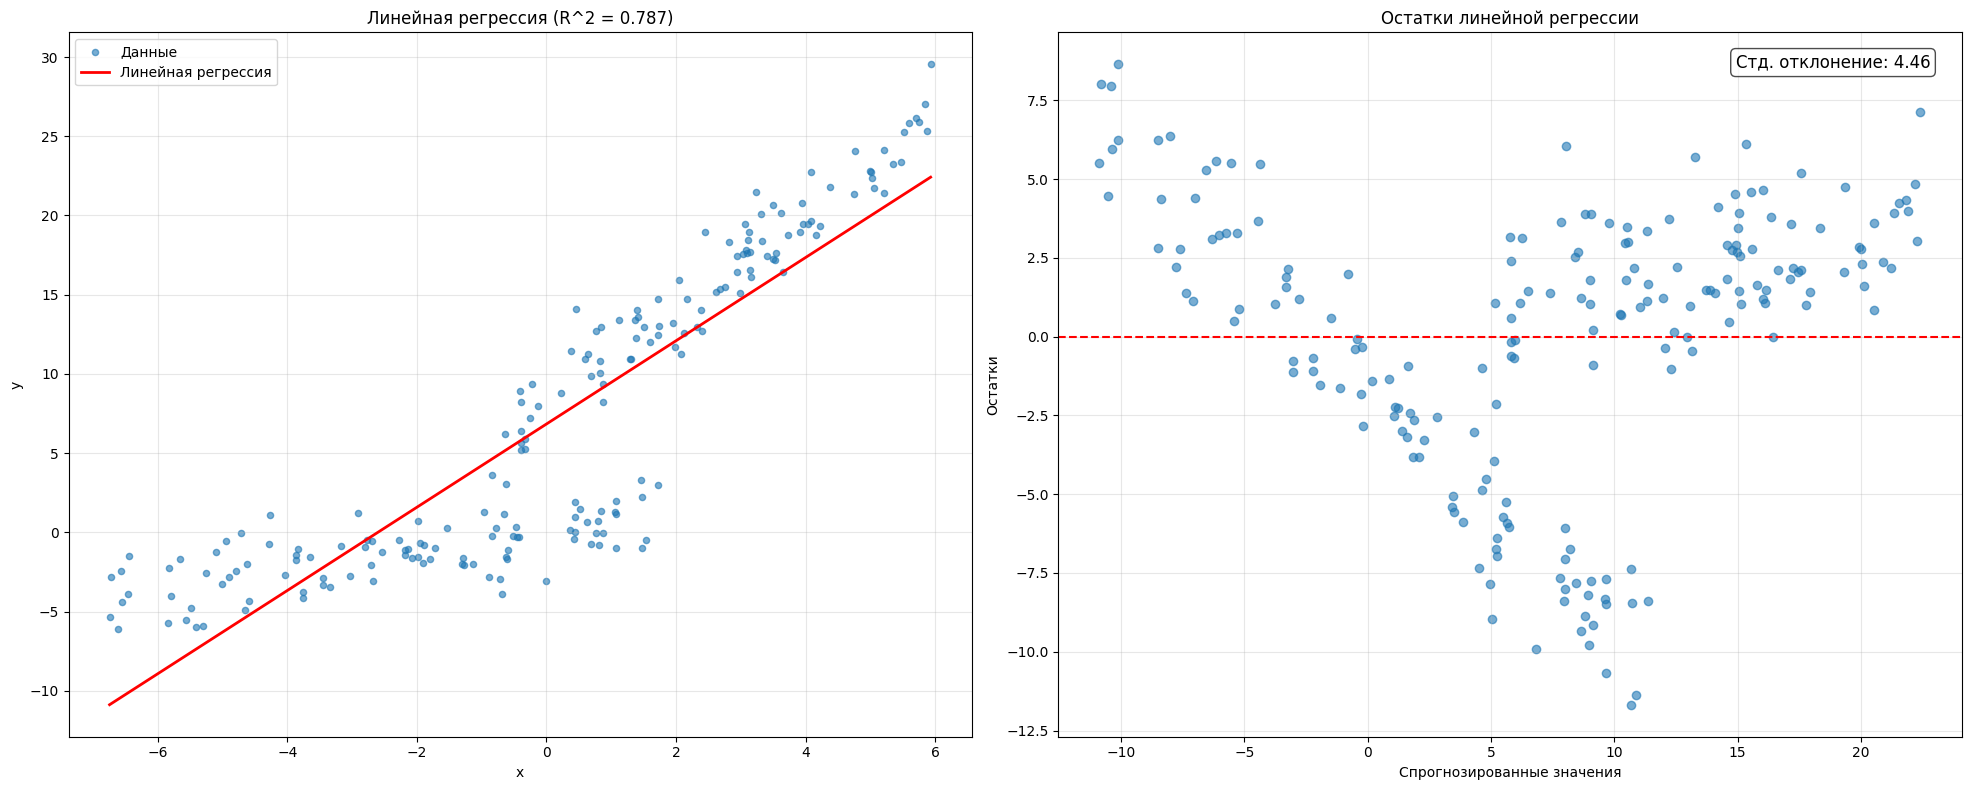


Выводы по данным:
1) Данные нелинейны
2) Оценка R^2 линейной регрессии около 79% => в данных присутствует значительное количество шума
3) СКО (MSE) довольно большое и значения прогноза довольно сильно отклоняются (на примерно 4,46) от реальных значений


In [60]:
# Загрузка данных
strange_data = pd.read_csv('hw2_strange_data.csv')
X_data = strange_data[['x']]
y_data = strange_data['y']

print(f'Размерность данных: {X_data.shape}')

# Линейная регрессия
lr = LinearRegression()
lr.fit(X_data, y_data)
y_pred_lr = lr.predict(X_data)

r2_lr = r2_score(y_data, y_pred_lr)
mse_lr = mean_squared_error(y_data, y_pred_lr)

print(f'Линейная регрессия - R^2: {r2_lr:.4f}, MSE: {mse_lr:.4f}')


# Визуализируем данные 
fig, axes = plt.subplots(1, 2, figsize=(20, 8))


# Линейная регрессия
x_plot = np.linspace(X_data.min(), X_data.max(), 300).reshape(-1, 1)
y_plot_lr = lr.predict(x_plot)

axes[0].scatter(X_data, y_data, alpha=0.6, s=20, label='Данные')
axes[0].plot(x_plot, y_plot_lr, 'r-', linewidth=2, label='Линейная регрессия')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Линейная регрессия (R^2 = {:.3f})'.format(r2_lr))
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# Анализируем распределения остатков (исходные данные - спрогнозированные значения)
residuals = y_data - y_pred_lr
axes[1].scatter(y_pred_lr, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Спрогнозированные значения')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Остатки линейной регрессии')
axes[1].text(0.75, 0.95, f'Стд. отклонение: {residuals.std():.2f}', 
             transform=axes[1].transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\nВыводы по данным:")
print("1) Данные нелинейны")
print("2) Оценка R^2 линейной регрессии около 79% => в данных присутствует значительное количество шума")
print("3) СКО (MSE) довольно большое и значения прогноза довольно сильно отклоняются (на примерно 4,46) от реальных значений")